# IMDb Review Classifier - Model Baseline
În acest notebook implementăm un model baseline folosind TF-IDF și Logistic Regression

In [18]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from src.preprocess import clean_text

In [19]:
print("Încărcăm dataset-ul IMDb...")
raw_ds = load_dataset("imdb")

# Păstrăm aceeași structură de split ca în EDA
split1 = raw_ds["train"].train_test_split(
    test_size=0.30,
    seed=42,
    stratify_by_column="label"
)
train_ds = split1["train"]
temp_ds = split1["test"]

split2 = temp_ds.train_test_split(
    test_size=0.50,
    seed=42,
    stratify_by_column="label"
)
val_ds = split2["train"]
test_ds = split2["test"]

# Convertim în DataFrame-uri
train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)

print("\nDimensiunile seturilor de date:")
print(f"Training:    {len(train_df):6d} exemple")
print(f"Validation:  {len(val_df):6d} exemple")
print(f"Test:        {len(test_df):6d} exemple")

Încărcăm dataset-ul IMDb...

Dimensiunile seturilor de date:
Training:     17500 exemple
Validation:    3750 exemple
Test:          3750 exemple


In [20]:
print("\nPreprocesăm textele...")
# Curățăm textele folosind funcția din preprocess.py
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)


Preprocesăm textele...


In [21]:
print("\nImplementăm vectorizatorul TF-IDF...")
# Configurăm vectorizatorul
tfidf = TfidfVectorizer(
    max_features=10000,  # Limităm la cele mai importante 10000 de cuvinte
    min_df=5,           # Ignorăm cuvintele care apar în mai puțin de 5 documente
    max_df=0.95,        # Ignorăm cuvintele care apar în mai mult de 95% din documente
    ngram_range=(1, 2),  # Folosim atât unigrams cât și bigrams
    stop_words='english'  # Eliminăm stop words-urile în engleză
)

# Fit și transformare pe setul de training
print("Fit și transformare pe setul de training...")
X_train = tfidf.fit_transform(train_df['cleaned_text'])
y_train = train_df['label']

# Transformare pe seturile de validare și test
print("Transformare pe seturile de validare și test...")
X_val = tfidf.transform(val_df['cleaned_text'])
y_val = val_df['label']
X_test = tfidf.transform(test_df['cleaned_text'])
y_test = test_df['label']

print(f"\nDimensiunea vocabularului: {len(tfidf.vocabulary_)}")
print(f"Dimensiunea matricei de training: {X_train.shape}")


Implementăm vectorizatorul TF-IDF...
Fit și transformare pe setul de training...
Transformare pe seturile de validare și test...

Dimensiunea vocabularului: 10000
Dimensiunea matricei de training: (17500, 10000)


In [22]:
print("\nImplementăm modelul Logistic Regression...")
# Configurăm modelul
model = LogisticRegression(
    C=1.0,              # Regularizare L2
    max_iter=1000,      # Număr maxim de iterații
    random_state=42,    # Pentru reproducibilitate
    n_jobs=-1           # Folosim toate nucleele disponibile
)

# Training
print("Training model...")
model.fit(X_train, y_train)


Implementăm modelul Logistic Regression...
Training model...


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [23]:
print("\nEvaluăm modelul pe setul de validare...")
y_val_pred = model.predict(X_val)

# Calculăm metricile
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("\nMetrici pe setul de validare:")
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-score:  {val_f1:.4f}")


Evaluăm modelul pe setul de validare...

Metrici pe setul de validare:
Accuracy:  0.8779
Precision: 0.8704
Recall:    0.8880
F1-score:  0.8791


In [24]:
# Cell 6.1: Grid Search pentru optimizarea hiperparametrilor
print("\nOptimizăm hiperparametrii folosind Grid Search...")
from sklearn.model_selection import GridSearchCV

# Definim parametrii pentru grid search
param_grid = {
    'C': [0.01, 0.1, 1.0],
    'penalty': ['l2'],  # Folosim doar L2 deoarece performează mai bine
    'solver': ['liblinear']
}

# Inițializăm modelul pentru grid search
grid_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    n_jobs=1  # Setăm n_jobs=1 pentru a evita avertismentele
)

# Configurăm grid search
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross validation
    scoring='f1',  # Optimizăm pentru F1-score
    n_jobs=-1,  # Paralelizăm grid search-ul
    verbose=1
)

# Rulăm grid search
print("Rulăm Grid Search (acest proces poate dura câteva minute)...")
grid_search.fit(X_train, y_train)

# Afișăm rezultatele
print("\nCei mai buni parametri găsiți:")
print(grid_search.best_params_)
print(f"\nCel mai bun F1-score: {grid_search.best_score_:.4f}")

# Afișăm toate rezultatele
print("\nRezultate pentru toate combinațiile de parametri:")
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_C', 'param_penalty', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))

# Actualizăm modelul cu cei mai buni parametri
print("\nActualizăm modelul cu cei mai buni parametri...")
model = grid_search.best_estimator_


Optimizăm hiperparametrii folosind Grid Search...
Rulăm Grid Search (acest proces poate dura câteva minute)...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Cei mai buni parametri găsiți:
{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

Cel mai bun F1-score: 0.8881

Rezultate pentru toate combinațiile de parametri:
   param_C param_penalty  mean_test_score  std_test_score
2     1.00            l2         0.888078        0.004341
1     0.10            l2         0.860287        0.004351
0     0.01            l2         0.829799        0.005874

Actualizăm modelul cu cei mai buni parametri...


In [25]:
print("\nEvaluăm modelul pe setul de test...")
y_test_pred = model.predict(X_test)

# Calculăm metricile
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nMetrici pe setul de test:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")


Evaluăm modelul pe setul de test...

Metrici pe setul de test:
Accuracy:  0.8781
Precision: 0.8700
Recall:    0.8891
F1-score:  0.8795



Matrice de confuzie:
Ox predictii:
0   1
0  1626   249
1   208  1667

Oy valori reale:
0   1
0  1626   249
1   208  1667


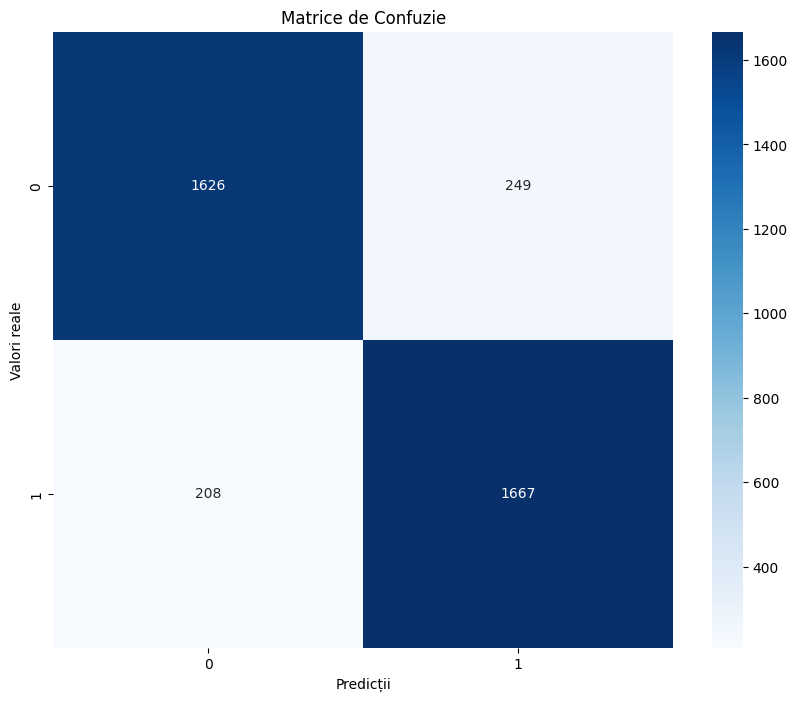

In [26]:
# Matrice de confuzie
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confuzie')
plt.xlabel('Predicții')
plt.ylabel('Valori reale')

# Afișăm și textul matricei de confuzie
print("\nMatrice de confuzie:")
print("Ox predictii:")
print("0   1")
print(f"0  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"1  {cm[1,0]:4d}  {cm[1,1]:4d}")
print("\nOy valori reale:")
print("0   1")
print(f"0  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"1  {cm[1,0]:4d}  {cm[1,1]:4d}")

plt.show()


Calculăm și afișăm ROC Curve...


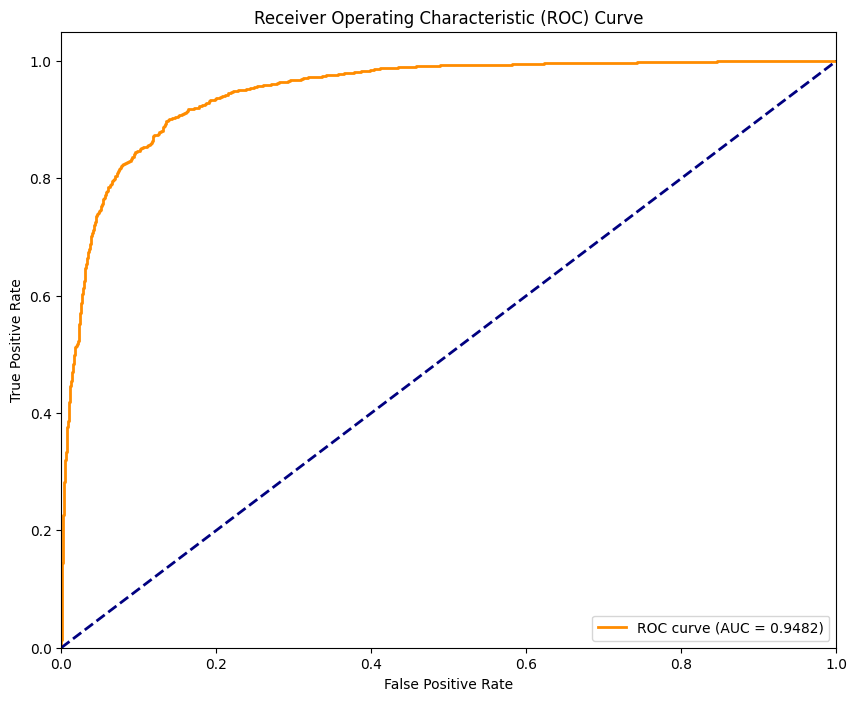


AUC Score: 0.9482


In [27]:
print("\nCalculăm și afișăm ROC Curve...")
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Obținem probabilitățile pentru clasa pozitivă
y_test_proba = model.predict_proba(X_test)[:, 1]

# Calculăm ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Calculăm AUC score
auc_score = roc_auc_score(y_test, y_test_proba)

# Afișăm ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Afișăm și AUC score-ul
print(f"\nAUC Score: {auc_score:.4f}")

In [28]:
print("\nAnalizăm câteva exemple de predicții...")
# Selectăm câteva exemple din setul de test
sample_indices = np.random.choice(len(test_df), 5, replace=False)
for idx in sample_indices:
    text = test_df.iloc[idx]['text']
    true_label = test_df.iloc[idx]['label']
    pred_label = y_test_pred[idx]
    
    print(f"\nExemplu {idx}:")
    print(f"Text: {text[:200]}...")
    print(f"Etichetă reală: {'Pozitiv' if true_label == 1 else 'Negativ'}")
    print(f"Predicție: {'Pozitiv' if pred_label == 1 else 'Negativ'}")
    print(f"Corect: {true_label == pred_label}")


Analizăm câteva exemple de predicții...

Exemplu 3541:
Text: This movie was probably about as silly as The Naked Gun (which was supposed to be). Case in point:<br /><br />1. In order to fake her drowning Roberts is secretly taking swimming lessons at the YWCA. ...
Etichetă reală: Negativ
Predicție: Negativ
Corect: True

Exemplu 828:
Text: I for one was glad to see Jim Carrey in a film where being over the top wasn't the goal. His character is like all of us. Wanting more - better things to happen to us and expecting God to deliver.<br ...
Etichetă reală: Pozitiv
Predicție: Pozitiv
Corect: True

Exemplu 1876:
Text: When this movie first came out back in 1984, Prince was one of the hottest acts around. Everyone wanted to see this movie, which was not much more than a extended music video. The acting was pretty ba...
Etichetă reală: Pozitiv
Predicție: Pozitiv
Corect: True

Exemplu 2179:
Text: The first half hour of the movie had a steady pace and introduced the characters. however all of

In [29]:
print("\nSalvăm modelul și metricile...")
import joblib
import json
from datetime import datetime

# Creăm directorul pentru modele dacă nu există
import os
os.makedirs('../models', exist_ok=True)

# Salvăm modelul
model_path = '../models/tfidf_logreg_baseline.joblib'
joblib.dump(model, model_path)

# Salvăm vectorizatorul
vectorizer_path = '../models/tfidf_vectorizer.joblib'
joblib.dump(tfidf, vectorizer_path)

# Salvăm metricile
metrics = {
    'validation': {
        'accuracy': float(val_accuracy),
        'precision': float(val_precision),
        'recall': float(val_recall),
        'f1_score': float(val_f1)
    },
    'test': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1)
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metrics_path = '../models/baseline_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print("\nModel și metrici salvate cu succes!")
print(f"Model salvat în: {model_path}")
print(f"Vectorizator salvat în: {vectorizer_path}")
print(f"Metrici salvate în: {metrics_path}")


Salvăm modelul și metricile...

Model și metrici salvate cu succes!
Model salvat în: ../models/tfidf_logreg_baseline.joblib
Vectorizator salvat în: ../models/tfidf_vectorizer.joblib
Metrici salvate în: ../models/baseline_metrics.json


# Pregătire Fine-Tuning (DistilBERT)

In [31]:
print("\nConfigurăm tokenizer-ul DistilBERT...")
from transformers import AutoTokenizer

# Încărcăm tokenizer-ul
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Afișăm informații despre tokenizer
print("\nInformații Tokenizer:")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Pad token ID: {tokenizer.pad_token_id}")
print(f"Unknown token ID: {tokenizer.unk_token_id}")
print(f"Max length implicit: {tokenizer.model_max_length}")

# Testăm tokenizer-ul pe câteva exemple
test_texts = [
    "This is a short review.",
    "This is a very long review that should be truncated. " * 50
]

print("\nTest tokenizer pe exemple:")
for text in test_texts:
    tokens = tokenizer.encode(text)
    print(f"\nText: {text[:50]}...")
    print(f"Număr tokeni: {len(tokens)}")
    print(f"Tokeni: {tokens[:10]}...")


Configurăm tokenizer-ul DistilBERT...


Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors



Informații Tokenizer:
Vocab size: 30522
Pad token ID: 0
Unknown token ID: 100
Max length implicit: 512

Test tokenizer pe exemple:

Text: This is a short review....
Număr tokeni: 8
Tokeni: [101, 2023, 2003, 1037, 2460, 3319, 1012, 102]...

Text: This is a very long review that should be truncate...
Număr tokeni: 552
Tokeni: [101, 2023, 2003, 1037, 2200, 2146, 3319, 2008, 2323, 2022]...


In [32]:
print("\nPregătim DataLoader-ul...")
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# Convertim DataFrame-urile în Dataset-uri Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Funcție de preprocesare pentru tokenizare
def preprocess_fn(batch):
    return tokenizer(
        batch["cleaned_text"],
        padding="max_length",
        truncation=True,
        max_length=512  # Folosim 512 conform EDA
    )

# Aplicăm preprocesarea
print("Tokenizăm seturile de date...")
train_dataset = train_dataset.map(preprocess_fn, batched=True)
val_dataset = val_dataset.map(preprocess_fn, batched=True)
test_dataset = test_dataset.map(preprocess_fn, batched=True)

# Configurăm DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Creăm DataLoader-uri
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

print(f"\nDimensiuni DataLoader:")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


Pregătim DataLoader-ul...
Tokenizăm seturile de date...


Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]


Dimensiuni DataLoader:
Training batches: 1094
Validation batches: 235
Test batches: 235


In [34]:
print("\nConfigurăm modelul DistilBERT...")
from transformers import AutoModelForSequenceClassification
import torch

# Verificăm și configurăm device-ul pentru M1 Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Folosim MPS (Metal Performance Shaders) pentru accelerare GPU")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Folosim CUDA pentru accelerare GPU")
else:
    device = torch.device("cpu")
    print("Folosim CPU (nu s-a găsit GPU disponibil)")

print(f"\nDevice configurat: {device}")

# Încărcăm modelul
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    dropout=0.1
)

# Mutăm modelul pe device-ul corespunzător
model = model.to(device)

# Afișăm configurația modelului
print("\nConfigurare model:")
print(f"Model type: {model.config.model_type}")
print(f"Vocab size: {model.config.vocab_size}")
print(f"Hidden size: {model.config.hidden_size}")
print(f"Număr de etichete: {model.config.num_labels}")
print(f"Dropout: {model.config.dropout}")


Configurăm modelul DistilBERT...
Folosim MPS (Metal Performance Shaders) pentru accelerare GPU

Device configurat: mps


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Configurare model:
Model type: distilbert
Vocab size: 30522
Hidden size: 768
Număr de etichete: 2
Dropout: 0.1


In [36]:
print("\nConfigurăm parametrii de training...")
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Calculăm numărul total de pași
num_epochs = 3
total_steps = len(train_dataloader) * num_epochs

# Configurăm optimizer
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)

# Configurăm scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

print("\nConfigurare training:")
print(f"Număr epoci: {num_epochs}")
print(f"Total pași: {total_steps}")
print(f"Warmup pași: {int(0.1 * total_steps)}")
print(f"Learning rate: 2e-5")
print(f"Weight decay: 0.01")



Configurăm parametrii de training...

Configurare training:
Număr epoci: 3
Total pași: 3282
Warmup pași: 328
Learning rate: 2e-5
Weight decay: 0.01


In [37]:
print("\nConfigurăm logging și checkpointing...")
import os
from datetime import datetime

# Creăm directoarele necesare
os.makedirs('../models/distilbert/checkpoints', exist_ok=True)
os.makedirs('../models/distilbert/final', exist_ok=True)
os.makedirs('../reports', exist_ok=True)

# Funcție pentru salvare checkpoint
def save_checkpoint(epoch, model, optimizer, scheduler, val_loss):
    checkpoint_dir = f'../models/distilbert/checkpoints/checkpoint-epoch{epoch}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': val_loss
    }, f'{checkpoint_dir}/checkpoint.pt')
    
    print(f"Checkpoint salvat în {checkpoint_dir}")

print("\nDirectoare create:")
print("- ../models/distilbert/checkpoints/")
print("- ../models/distilbert/final/")
print("- ../reports/")


Configurăm logging și checkpointing...

Directoare create:
- ../models/distilbert/checkpoints/
- ../models/distilbert/final/
- ../reports/


In [38]:
print("\nDefinim funcțiile de training și evaluare...")

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in dataloader:
        # Mutăm batch-ul pe device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Calculăm metrici
        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (predictions == batch['labels']).sum().item()
        total_predictions += len(batch['labels'])
    
    return total_loss / len(dataloader), correct_predictions / total_predictions

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()
            total_predictions += len(batch['labels'])
    
    return total_loss / len(dataloader), correct_predictions / total_predictions

print("\nFuncții definite:")
print("- train_epoch: pentru antrenarea unei epoci")
print("- evaluate: pentru evaluarea modelului")


Definim funcțiile de training și evaluare...

Funcții definite:
- train_epoch: pentru antrenarea unei epoci
- evaluate: pentru evaluarea modelului


In [ ]:
print("\nConfigurăm Early Stopping...")

class EarlyStopping:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=2)
print("Early stopping configurat cu patience=2")

print("\nPregătirea pentru Fine-Tuning este completă!")
print("Următorii pași:")
print("1. Rularea training-ului")
print("2. Evaluarea modelului")
print("3. Salvarea modelului final")
print("4. Generarea raportului")


Configurăm Early Stopping...
Early stopping configurat cu patience=2

Pregătirea pentru Fine-Tuning este completă!
Următorii pași:
1. Rularea training-ului
2. Evaluarea modelului
3. Salvarea modelului final
4. Generarea raportului
